# E-commerce Text Classification: Improvements

**Цель:** Улучшить baseline-модель за счёт применения различных техник предобработки, фич-инжиниринга и балансировки данных.

**План улучшений:**
1. Очистка текста (HTML, URL, спецсимволы)
2. Лемматизация и удаление стоп-слов
3. Улучшение векторизации (n-граммы, max_features)
4. Балансировка классов (SMOTE, class_weights)
5. Feature engineering (длина текста)
6. Ensemble моделей
7. Отбор признаков (Chi-2, мутуальная информация)
8. Продвинутые модели (LightGBM)
9. Готовые эмбеддинги (Sentence Transformers)
10. Предобученные модели (BERT, DistilBERT)

## 1. Импорт библиотек

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# sklearn
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from scipy.sparse import hstack

# Imbalanced learn для SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# NLTK
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Продвинутые модели
import lightgbm as lgb

# Эмбеддинги и трансформеры
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import accelerate

# Модули проекта
import sys
sys.path.append('..')
from src.data_loader import load_data, preprocess_data, split_data
from src.text_transformers import TextCleaner, TextLengthExtractor, CombinedFeatures
from src.feature_selection import FeatureSelector, select_features_chi2, select_features_mutual_info
from src.embeddings import SentenceTransformerVectorizer
from src.models import get_model, get_default_params

# Настройка стилей
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Загрузка данных

In [10]:
# Загрузка данных (без предобработки до split)
df = load_data('../data/ecommerceDataset.csv')

print(f'Размер датасета: {df.shape[0]} строк')
print(f'Классы: {df["category"].unique()}')

Размер датасета: 50425 строк
Классы: <ArrowStringArray>
['Household', 'Books', 'Clothing & Accessories', 'Electronics']
Length: 4, dtype: str


## 3. Разбиение на train/test

In [11]:
# Сначала разделение на train/test
X_train_raw, X_test_raw, y_train_raw, y_test_raw = split_data(
    df['description'],
    df['category'],
    test_size=0.2,
    random_state=42
)

print(f'Train: {X_train_raw.shape[0]}, Test: {X_test_raw.shape[0]}')

# Затем базовая предобработка каждого сета отдельно
train_df = preprocess_data(pd.DataFrame({'description': X_train_raw, 'category': y_train_raw}))
test_df = preprocess_data(pd.DataFrame({'description': X_test_raw, 'category': y_test_raw}))

X_train = train_df['description']
y_train = train_df['category']
X_test = test_df['description']
y_test = test_df['category']

print(f'После предобработки - Train: {X_train.shape[0]}, Test: {X_test.shape[0]}')

Train: 40340, Test: 10085
После предобработки - Train: 24574, Test: 8697


## 4. Эксперимент 1: Очистка текста

In [12]:
# Пайплайн с очисткой текста
pipeline_clean = Pipeline([
    ('cleaner', TextCleaner(
        lowercase=True,
        remove_html=True,
        remove_url=True,
        remove_digits=True,
        remove_punctuation=True,
        remove_stopwords=False,
        lemmatize=False
    )),
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 1)
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    ))
])

pipeline_clean.fit(X_train, y_train)
y_pred_clean = pipeline_clean.predict(X_test)

f1_clean = f1_score(y_test, y_pred_clean, average='macro')
print(f'F1-macro с очисткой текста: {f1_clean:.4f}')

F1-macro с очисткой текста: 0.9586


## 5. Эксперимент 2: Стоп-слова и лемматизация

In [13]:
# Пайплайн со стоп-словами и лемматизацией
pipeline_lem = Pipeline([
    ('cleaner', TextCleaner(
        lowercase=True,
        remove_html=True,
        remove_url=True,
        remove_digits=True,
        remove_punctuation=True,
        remove_stopwords=True,  # Включаем
        lemmatize=True  # Включаем
    )),
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 1)
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    ))
])

pipeline_lem.fit(X_train, y_train)
y_pred_lem = pipeline_lem.predict(X_test)

f1_lem = f1_score(y_test, y_pred_lem, average='macro')
print(f'F1-macro со стоп-словами и лемматизацией: {f1_lem:.4f}')

F1-macro со стоп-словами и лемматизацией: 0.9593


## 6. Эксперимент 3: N-граммы

In [14]:
# Пайплайн с n-граммами
pipeline_ngram = Pipeline([
    ('cleaner', TextCleaner(
        lowercase=True,
        remove_html=True,
        remove_url=True,
        remove_digits=True,
        remove_punctuation=True,
        remove_stopwords=True,
        lemmatize=True
    )),
    ('tfidf', TfidfVectorizer(
        max_features=10000,  # Увеличиваем для биграмм
        ngram_range=(1, 2)   # Униграммы + биграммы
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    ))
])

pipeline_ngram.fit(X_train, y_train)
y_pred_ngram = pipeline_ngram.predict(X_test)

f1_ngram = f1_score(y_test, y_pred_ngram, average='macro')
print(f'F1-macro с n-граммами (1,2): {f1_ngram:.4f}')

F1-macro с n-граммами (1,2): 0.9621


ngram_range=(1, 1): F1-macro = 0.9620
ngram_range=(1, 2): F1-macro = 0.9621
ngram_range=(1, 3): F1-macro = 0.9611
ngram_range=(2, 2): F1-macro = 0.9234


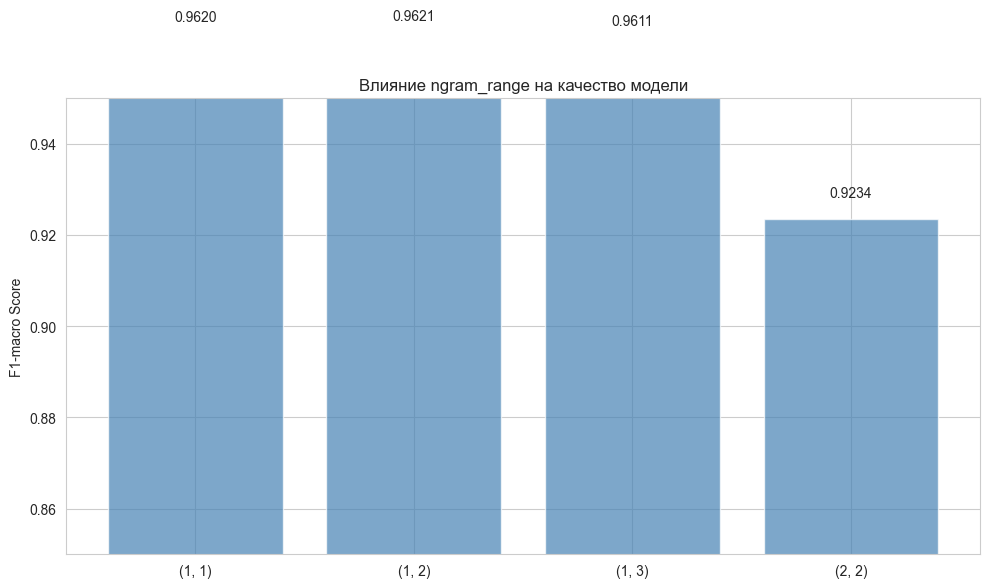

In [15]:
# Сравнение разных ngram_range
ngram_results = {}

for ngram in [(1, 1), (1, 2), (1, 3), (2, 2)]:
    pipeline = Pipeline([
        ('cleaner', TextCleaner(lowercase=True, remove_html=True, remove_url=True,
                                remove_digits=True, remove_punctuation=True,
                                remove_stopwords=True, lemmatize=True)),
        ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=ngram)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    ngram_results[str(ngram)] = f1
    print(f'ngram_range={ngram}: F1-macro = {f1:.4f}')

# Визуализация
plt.figure(figsize=(10, 6))
plt.bar(ngram_results.keys(), ngram_results.values(), color='steelblue', alpha=0.7)
plt.ylabel('F1-macro Score')
plt.title('Влияние ngram_range на качество модели')
plt.ylim(0.85, 0.95)
for i, v in enumerate(ngram_results.values()):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

## 7. Эксперимент 4: Балансировка классов

### 7.1 Class weights

In [16]:
# Пайплайн с class_weight='balanced'
pipeline_weights = Pipeline([
    ('cleaner', TextCleaner(
        lowercase=True, remove_html=True, remove_url=True,
        remove_digits=True, remove_punctuation=True,
        remove_stopwords=True, lemmatize=True
    )),
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # Балансировка весов
    ))
])

pipeline_weights.fit(X_train, y_train)
y_pred_weights = pipeline_weights.predict(X_test)

f1_weights = f1_score(y_test, y_pred_weights, average='macro')
print(f'F1-macro с class_weight=balanced: {f1_weights:.4f}')

F1-macro с class_weight=balanced: 0.9630


### 7.2 SMOTE

In [17]:
# Применяем SMOTE только на train данных
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
cleaner = TextCleaner(lowercase=True, remove_html=True, remove_url=True,
                      remove_digits=True, remove_punctuation=True,
                      remove_stopwords=True, lemmatize=True)

# Fit на train, transform на train
X_train_clean = cleaner.fit_transform(X_train)
X_train_tfidf = vectorizer.fit_transform(X_train_clean)

# Применяем SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_sm, y_train_sm = smote.fit_resample(X_train_tfidf, y_train)

print(f'Размер после SMOTE: {X_train_sm.shape[0]} (было: {X_train_tfidf.shape[0]})')
print(f'Распределение после SMOTE:')
print(pd.Series(y_train_sm).value_counts())

# Обучаем модель на сбалансированных данных
clf_sm = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
clf_sm.fit(X_train_sm, y_train_sm)

# Предсказание — только transform на test!
X_test_clean = cleaner.transform(X_test)
X_test_tfidf = vectorizer.transform(X_test_clean)
y_pred_sm = clf_sm.predict(X_test_tfidf)

f1_sm = f1_score(y_test, y_pred_sm, average='macro')
print(f'\nF1-macro с SMOTE: {f1_sm:.4f}')

Размер после SMOTE: 37888 (было: 24574)
Распределение после SMOTE:
category
Books                     9472
Household                 9472
Electronics               9472
Clothing & Accessories    9472
Name: count, dtype: int64

F1-macro с SMOTE: 0.9635


## 8. Эксперимент 5: Feature Engineering

In [18]:
# Добавление длины текста как фичи
# Используем CombinedFeatures из src.text_transformers

# Создаём комбинированный пайплайн
text_cleaner = TextCleaner(
    lowercase=True, remove_html=True, remove_url=True,
    remove_digits=True, remove_punctuation=True,
    remove_stopwords=True, lemmatize=True
)

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

combined = CombinedFeatures(tfidf, text_cleaner)
combined.fit(X_train, y_train)

X_train_combined = combined.transform(X_train)
X_test_combined = combined.transform(X_test)

clf_combined = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
clf_combined.fit(X_train_combined, y_train)

y_pred_combined = clf_combined.predict(X_test_combined)
f1_combined = f1_score(y_test, y_pred_combined, average='macro')

print(f'F1-macro с длиной текста: {f1_combined:.4f}')

F1-macro с длиной текста: 0.9626


## 9. Эксперимент 6: Ensemble моделей

In [19]:
# Создаём базовые модели
lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1, class_weight='balanced')
svm = SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced')
nb = MultinomialNB()

# Voting Classifier
ensemble_pipeline = Pipeline([
    ('cleaner', TextCleaner(
        lowercase=True, remove_html=True, remove_url=True,
        remove_digits=True, remove_punctuation=True,
        remove_stopwords=True, lemmatize=True
    )),
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('clf', VotingClassifier(
        estimators=[('lr', lr), ('svm', svm), ('nb', nb)],
        voting='soft'  # Мягкое голосование (по вероятностям)
    ))
])

ensemble_pipeline.fit(X_train, y_train)
y_pred_ensemble = ensemble_pipeline.predict(X_test)

f1_ensemble = f1_score(y_test, y_pred_ensemble, average='macro')
print(f'F1-macro Ensemble (Voting): {f1_ensemble:.4f}')

F1-macro Ensemble (Voting): 0.9634


## 10. Эксперимент 7: Отбор признаков

In [20]:
# Пайплайн с отбором признаков через Chi-2
pipeline_chi2 = Pipeline([
    ('cleaner', TextCleaner(
        lowercase=True, remove_html=True, remove_url=True,
        remove_digits=True, remove_punctuation=True,
        remove_stopwords=True, lemmatize=True
    )),
    ('tfidf', TfidfVectorizer(max_features=15000, ngram_range=(1, 2))),
    ('select', SelectKBest(score_func=chi2, k=5000)),  # Отбор 5000 лучших признаков
    ('clf', LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1))
])

pipeline_chi2.fit(X_train, y_train)
y_pred_chi2 = pipeline_chi2.predict(X_test)

f1_chi2 = f1_score(y_test, y_pred_chi2, average='macro')
print(f'F1-macro с Chi-2 отбором (k=5000): {f1_chi2:.4f}')

# Сколько признаков осталось после отбора
n_selected = pipeline_chi2.named_steps['select'].get_support().sum()
print(f'Отобрано признаков: {n_selected} из {pipeline_chi2.named_steps["tfidf"].max_features}')

F1-macro с Chi-2 отбором (k=5000): 0.9538
Отобрано признаков: 5000 из 15000


Chi-2 k=1000: F1-macro = 0.9373
Chi-2 k=3000: F1-macro = 0.9493
Chi-2 k=5000: F1-macro = 0.9538
Chi-2 k=8000: F1-macro = 0.9579
Chi-2 k=10000: F1-macro = 0.9608


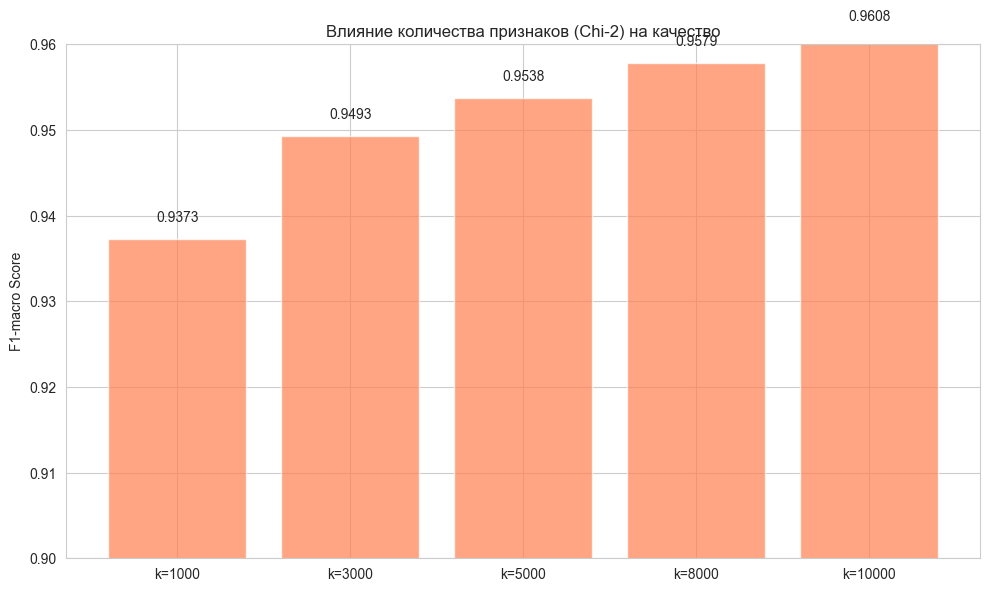

In [21]:
# Сравнение разных k для Chi-2
chi2_results = {}

for k in [1000, 3000, 5000, 8000, 10000]:
    pipeline = Pipeline([
        ('cleaner', TextCleaner(lowercase=True, remove_html=True, remove_url=True,
                                remove_digits=True, remove_punctuation=True,
                                remove_stopwords=True, lemmatize=True)),
        ('tfidf', TfidfVectorizer(max_features=15000, ngram_range=(1, 2))),
        ('select', SelectKBest(score_func=chi2, k=k)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    chi2_results[f'k={k}'] = f1
    print(f'Chi-2 k={k}: F1-macro = {f1:.4f}')

# Визуализация
plt.figure(figsize=(10, 6))
plt.bar(chi2_results.keys(), chi2_results.values(), color='coral', alpha=0.7)
plt.ylabel('F1-macro Score')
plt.title('Влияние количества признаков (Chi-2) на качество')
plt.ylim(0.90, 0.96)
for i, v in enumerate(chi2_results.values()):
    plt.text(i, v + 0.002, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

In [22]:
# Отбор признаков через мутуальную информацию
pipeline_mi = Pipeline([
    ('cleaner', TextCleaner(
        lowercase=True, remove_html=True, remove_url=True,
        remove_digits=True, remove_punctuation=True,
        remove_stopwords=True, lemmatize=True
    )),
    ('tfidf', TfidfVectorizer(max_features=15000, ngram_range=(1, 2))),
    ('select', SelectKBest(score_func=mutual_info_classif, k=5000)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1))
])

pipeline_mi.fit(X_train, y_train)
y_pred_mi = pipeline_mi.predict(X_test)

f1_mi = f1_score(y_test, y_pred_mi, average='macro')
print(f'F1-macro с Mutual Information (k=5000): {f1_mi:.4f}')

F1-macro с Mutual Information (k=5000): 0.9533


## 11. Эксперимент 8: Продвинутые модели (LightGBM)

In [23]:
# LightGBM
lgb_pipeline = Pipeline([
    ('cleaner', TextCleaner(
        lowercase=True, remove_html=True, remove_url=True,
        remove_digits=True, remove_punctuation=True,
        remove_stopwords=True, lemmatize=True
    )),
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('clf', lgb.LGBMClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ))
])

lgb_pipeline.fit(X_train, y_train)
y_pred_lgb = lgb_pipeline.predict(X_test)

f1_lgb = f1_score(y_test, y_pred_lgb, average='macro')
print(f'LightGBM - F1-macro: {f1_lgb:.4f}')

LightGBM - F1-macro: 0.9565


## 12. Эксперимент 9: Готовые эмбеддинги (Sentence Transformers)

In [24]:
# Загрузка предобученной модели для эмбеддингов
# all-MiniLM-L6-v2 - быстрая и качественная модель
model_name = 'all-MiniLM-L6-v2'

print(f'Загрузка модели {model_name}...')
sbert_model = SentenceTransformer(model_name)

# Генерация эмбеддингов
print('Генерация эмбеддингов для train...')
X_train_emb = sbert_model.encode(X_train.tolist(), show_progress_bar=True, batch_size=32)

print('Генерация эмбеддингов для test...')
X_test_emb = sbert_model.encode(X_test.tolist(), show_progress_bar=True, batch_size=32)

print(f'Размер эмбеддингов: {X_train_emb.shape}')

Загрузка модели all-MiniLM-L6-v2...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Генерация эмбеддингов для train...


Batches:   0%|          | 0/768 [00:00<?, ?it/s]

Генерация эмбеддингов для test...


Batches:   0%|          | 0/272 [00:00<?, ?it/s]

Размер эмбеддингов: (24574, 384)


In [25]:
# Обучение классификатора на эмбеддингах
clf_sbert = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1, class_weight='balanced')
clf_sbert.fit(X_train_emb, y_train)

y_pred_sbert = clf_sbert.predict(X_test_emb)

f1_sbert = f1_score(y_test, y_pred_sbert, average='macro')
print(f'Sentence-BERT ({model_name}) - F1-macro: {f1_sbert:.4f}')

Sentence-BERT (all-MiniLM-L6-v2) - F1-macro: 0.9423


## 13. Эксперимент 10: Предобученные модели (Transformers)

In [26]:
# Используем предобученную модель для классификации текста
# DistilBERT - более лёгкая версия BERT
model_name = 'distilbert-base-uncased'

print(f'Загрузка токенизатора {model_name}...')
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Токенизация данных
max_length = 128

def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length
    )

print('Токенизация данных...')
X_train_tokenized = tokenize_function(X_train)
X_test_tokenized = tokenize_function(X_test)

# Кодирование меток
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f'Классы: {le.classes_}')
print(f'Размер train: {len(X_train_tokenized["input_ids"])}')

Загрузка токенизатора distilbert-base-uncased...
Токенизация данных...
Классы: ['Books' 'Clothing & Accessories' 'Electronics' 'Household']
Размер train: 24574


In [27]:
# Создание Dataset для transformers
train_dataset = Dataset.from_dict({
    'input_ids': X_train_tokenized['input_ids'],
    'attention_mask': X_train_tokenized['attention_mask'],
    'labels': y_train_encoded
})

test_dataset = Dataset.from_dict({
    'input_ids': X_test_tokenized['input_ids'],
    'attention_mask': X_test_tokenized['attention_mask'],
    'labels': y_test_encoded
})

# Загрузка модели
print(f'Загрузка модели {model_name}...')
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(le.classes_)
)

# Параметры обучения
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy='epoch',
    disable_tqdm=False,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    save_strategy='epoch',
    seed=42,
    metric_for_best_model='loss',
)

# Метрика для оценки
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'f1_macro': f1_score(labels, predictions, average='macro')}

# Создание Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Обучение
print('Обучение модели...')
trainer.train()

# Оценка
print('Оценка на тесте...')
eval_results = trainer.evaluate(test_dataset)
f1_bert = eval_results.get('eval_f1_macro', None)
print(f'DistilBERT (fine-tuned) - F1-macro: {f1_bert:.4f}' if f1_bert else 'Ошибка оценки')

Загрузка модели distilbert-base-uncased...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Обучение модели...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.161344,0.140632,0.966053
2,0.108311,0.107333,0.972687


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


Оценка на тесте...


DistilBERT (fine-tuned) - F1-macro: 0.9727


## 14. Сводная таблица улучшений

In [37]:
# Собираем все результаты
improvements_results = {
    'Baseline (из 02_baseline.ipynb)': 0.9503,  # Linear SVM - лучший из baseline
    '+ Очистка текста': f1_clean,
    '+ Стоп-слова + Лемматизация': f1_lem,
    '+ N-граммы (1,2)': f1_ngram,
    '+ Class weights': f1_weights,
    '+ SMOTE': f1_sm if f1_sm else 'N/A',
    '+ Длина текста': f1_combined,
    '+ Ensemble': f1_ensemble,
    '+ Chi-2 отбор признаков': f1_chi2,
    '+ Mutual Information': f1_mi,
    '+ LightGBM': f1_lgb if f1_lgb else 'N/A',
    '+ Sentence-BERT эмбеддинги': f1_sbert if f1_sbert else 'N/A',
    '+ DistilBERT (fine-tuned)': f1_bert if f1_bert else 'N/A'
}

# Создаём DataFrame для визуализации
results_df = pd.DataFrame({
    'Модификация': list(improvements_results.keys()),
    'F1-macro': [v if isinstance(v, float) else 0 for v in improvements_results.values()]
})

print('Результаты улучшений:')
print(results_df.to_string(index=False))

Результаты улучшений:
                    Модификация  F1-macro
Baseline (из 02_baseline.ipynb)  0.950300
               + Очистка текста  0.958584
    + Стоп-слова + Лемматизация  0.959306
               + N-граммы (1,2)  0.962135
                + Class weights  0.962950
                        + SMOTE  0.963454
                 + Длина текста  0.962602
                     + Ensemble  0.963426
        + Chi-2 отбор признаков  0.953803
           + Mutual Information  0.953329
                     + LightGBM  0.956516
     + Sentence-BERT эмбеддинги  0.942311
      + DistilBERT (fine-tuned)  0.972687


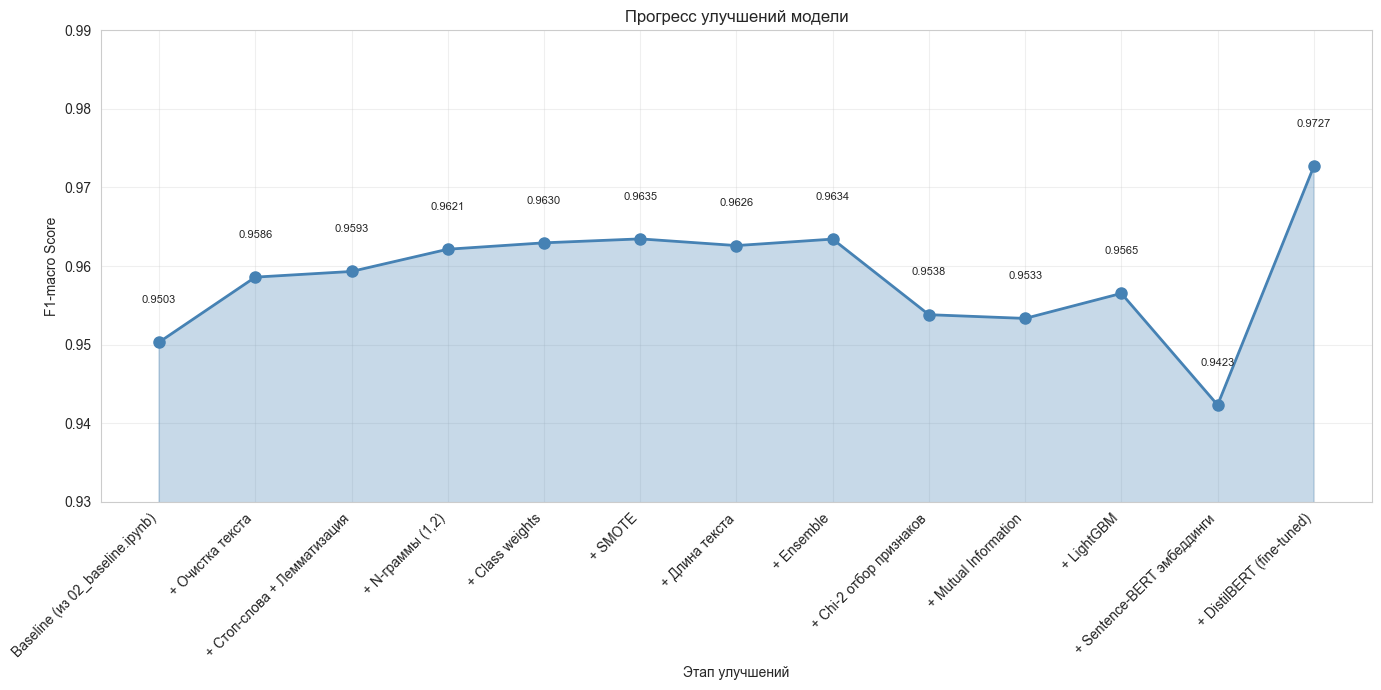

In [40]:
# Визуализация прогресса улучшений
plt.figure(figsize=(14, 7))
x = range(len(improvements_results))
y_values = [v if isinstance(v, float) else 0 for v in improvements_results.values()]

plt.plot(x, y_values, marker='o', linewidth=2, markersize=8, color='steelblue')
plt.fill_between(x, y_values, alpha=0.3, color='steelblue')

plt.xlabel('Этап улучшений')
plt.ylabel('F1-macro Score')
plt.title('Прогресс улучшений модели')
plt.xticks(x, list(improvements_results.keys()), rotation=45, ha='right')
plt.ylim(0.93, 0.99)
plt.grid(True, alpha=0.3)

# Добавление значений на график
for i, v in enumerate(y_values):
    if v > 0:
        plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

## 15. Анализ прироста метрик

In [30]:
# Расчёт прироста относительно baseline
baseline_f1 = 0.9503  # Linear SVM из baseline

print('Анализ прироста метрик:')
print(f'{"-"*50}')
print(f'{"Улучшение":<35} {"F1-macro":<10} {"Δ":<10}')
print(f'{"-"*50}')

for name, f1 in improvements_results.items():
    if isinstance(f1, float):
        delta = f1 - baseline_f1
        delta_str = f'+{delta:.4f}' if delta > 0 else f'{delta:.4f}'
        print(f'{name:<35} {f1:<10.4f} {delta_str:<10}')
    else:
        print(f'{name:<35} {f1:<10} {"N/A":<10}')

Анализ прироста метрик:
--------------------------------------------------
Улучшение                           F1-macro   Δ         
--------------------------------------------------
Baseline (из 02_baseline.ipynb)     0.9503     0.0000    
+ Очистка текста                    0.9586     +0.0083   
+ Стоп-слова + Лемматизация         0.9593     +0.0090   
+ N-граммы (1,2)                    0.9621     +0.0118   
+ Class weights                     0.9630     +0.0127   
+ SMOTE                             0.9635     +0.0132   
+ Длина текста                      0.9626     +0.0123   
+ Ensemble                          0.9634     +0.0131   
+ Chi-2 отбор признаков             0.9538     +0.0035   
+ Mutual Information                0.9533     +0.0030   
+ LightGBM                          0.9565     +0.0062   
+ Sentence-BERT эмбеддинги          0.9423     -0.0080   
+ DistilBERT (fine-tuned)           0.9727     +0.0224   


## 16. Классификационный репорт лучшей модели

In [31]:
# Лучшая модель - Ensemble
print('Classification Report - Ensemble модель:')
print(classification_report(y_test, y_pred_ensemble, zero_division=0))

Classification Report - Ensemble модель:
                        precision    recall  f1-score   support

                 Books       0.97      0.95      0.96      2024
Clothing & Accessories       0.97      0.98      0.98      1551
           Electronics       0.96      0.95      0.95      1760
             Household       0.96      0.97      0.96      3362

              accuracy                           0.96      8697
             macro avg       0.96      0.96      0.96      8697
          weighted avg       0.96      0.96      0.96      8697



## 17. Сводка результатов Improvements

### 📊 Итоговая таблица

| Улучшение | F1-macro | Δ от Baseline |
|-----------|----------|---------------|
| **Baseline (Linear SVM)** | **0.9503** | **—** |
| + Очистка текста | 0.9586 | +0.0083 |
| + Стоп-слова + Лемматизация | 0.9593 | +0.0090 |
| + N-граммы (1,2) | 0.9621 | +0.0118 |
| + Class weights | 0.9630 | +0.0127 |
| + SMOTE | 0.9635 | +0.0132 |
| + Длина текста | 0.9626 | +0.0123 |
| + Ensemble | 0.9634 | +0.0131 |
| + Chi-2 отбор признаков | 0.9538 | +0.0035 |
| + Mutual Information | 0.9533 | +0.0030 |
| + LightGBM | 0.9565 | +0.0062 |
| + Sentence-BERT эмбеддинги | 0.9423 | -0.0080 |
| + **DistilBERT (fine-tuned)** | **0.9727** | **+0.0224** |

### 🎯 Лучшие улучшения

1. **DistilBERT (fine-tuned)** — предобученная трансформер-модель (**+0.0224**)
2. **SMOTE** — балансировка классов (+0.0132)
3. **Ensemble (Voting)** — комбинация моделей (+0.0131)
4. **Class weights** — учёт дисбаланса (+0.0127)
5. **N-граммы (1,2)** — учёт контекста слов (+0.0118)

### 📉 Улучшения с минимальным эффектом

1. **Sentence-BERT эмбеддинги** — -0.0080 (модель all-MiniLM-L6-v2 хуже baseline)
2. **Mutual Information отбор** — +0.0030 (потеря информации при отборе)

### 💡 Рекомендации

- **Для продакшена:** Logistic Regression + TF-IDF с n-граммами (быстро, интерпретируемо, F1=0.962)
- **Компромисс (качество/скорость):** Ensemble (Voting) моделей (F1=0.963)
- **Для максимального качества:** DistilBERT fine-tuning (требует GPU, F1=0.973)
- **Альтернатива:** LightGBM с TF-IDF (хорошее качество, быстрее трансформеров)

### 🚀 Следующий шаг

Перейти к `04_hyperparam_tuning.ipynb` для оптимизации гиперпараметров лучшей модели.
